In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.lstm import LSTMModel
from src.training_utils import *

### Load segmented data

In [2]:
# load data splits
data_dir = '../Old_Young_Walking_Data/'
train_data = np.load(data_dir + 'Silder_mixed_train_data.npz')
val_data = np.load(data_dir + 'Silder_mixed_val_data.npz')
test_data = np.load(data_dir + 'Silder_mixed_test_data.npz')
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

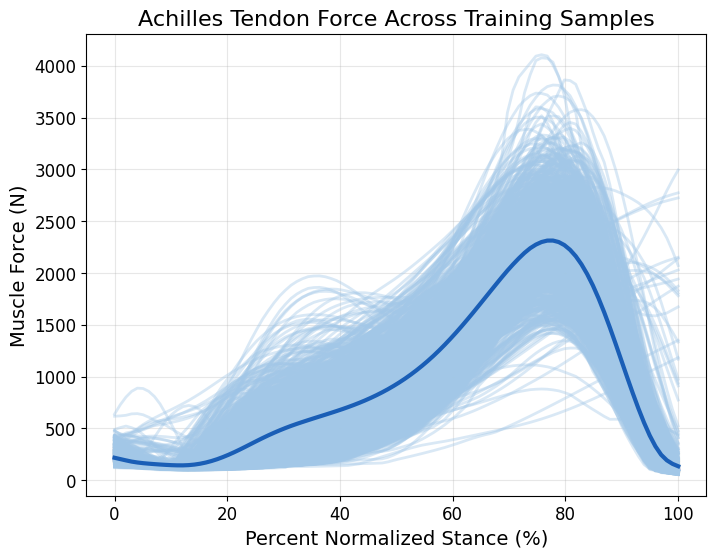

In [3]:
# plot data to double check
plot_achilles_force(y_train)

### Initialize model

In [4]:
# model parameters
input_size = 3  # grf features (x, y, z)
hidden_size = 64  # hidden size for LSTM (tunable)
num_layers = 2  # number of LSTM layers
output_size = 9  # muscle force features

# create the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [5]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
# move the model to the device
model.to(device)

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

### Initialize hyperparameters and data loaders

In [7]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### Train model

In [8]:
best_model, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 174905.7902, Val Loss: 124882.9924
Epoch [10/1000], Train Loss: 168265.1510, Val Loss: 119211.7515
Epoch [20/1000], Train Loss: 162663.3767, Val Loss: 114347.5965
Epoch [30/1000], Train Loss: 157619.1602, Val Loss: 110030.7243
Epoch [40/1000], Train Loss: 152967.8249, Val Loss: 106106.9784
Epoch [50/1000], Train Loss: 148620.2593, Val Loss: 102491.6013
Epoch [60/1000], Train Loss: 144517.9290, Val Loss: 99120.9374
Epoch [70/1000], Train Loss: 140620.3222, Val Loss: 95956.1664
Epoch [80/1000], Train Loss: 136900.6719, Val Loss: 92967.1637
Epoch [90/1000], Train Loss: 133339.1532, Val Loss: 90139.4177
Epoch [100/1000], Train Loss: 129921.8093, Val Loss: 87450.5464
Epoch [110/1000], Train Loss: 126635.5244, Val Loss: 84892.9964
Epoch [120/1000], Train Loss: 123469.7364, Val Loss: 82455.5557
Epoch [130/1000], Train Loss: 120416.6457, Val Loss: 80128.4678
Epoch [140/1000], Train Loss: 117112.8962, Val Loss: 77613.3866
Epoch [150/1000], Train Loss: 114076.7209, Va

### Test model

In [9]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 24948.2285


### Plot sample prediction

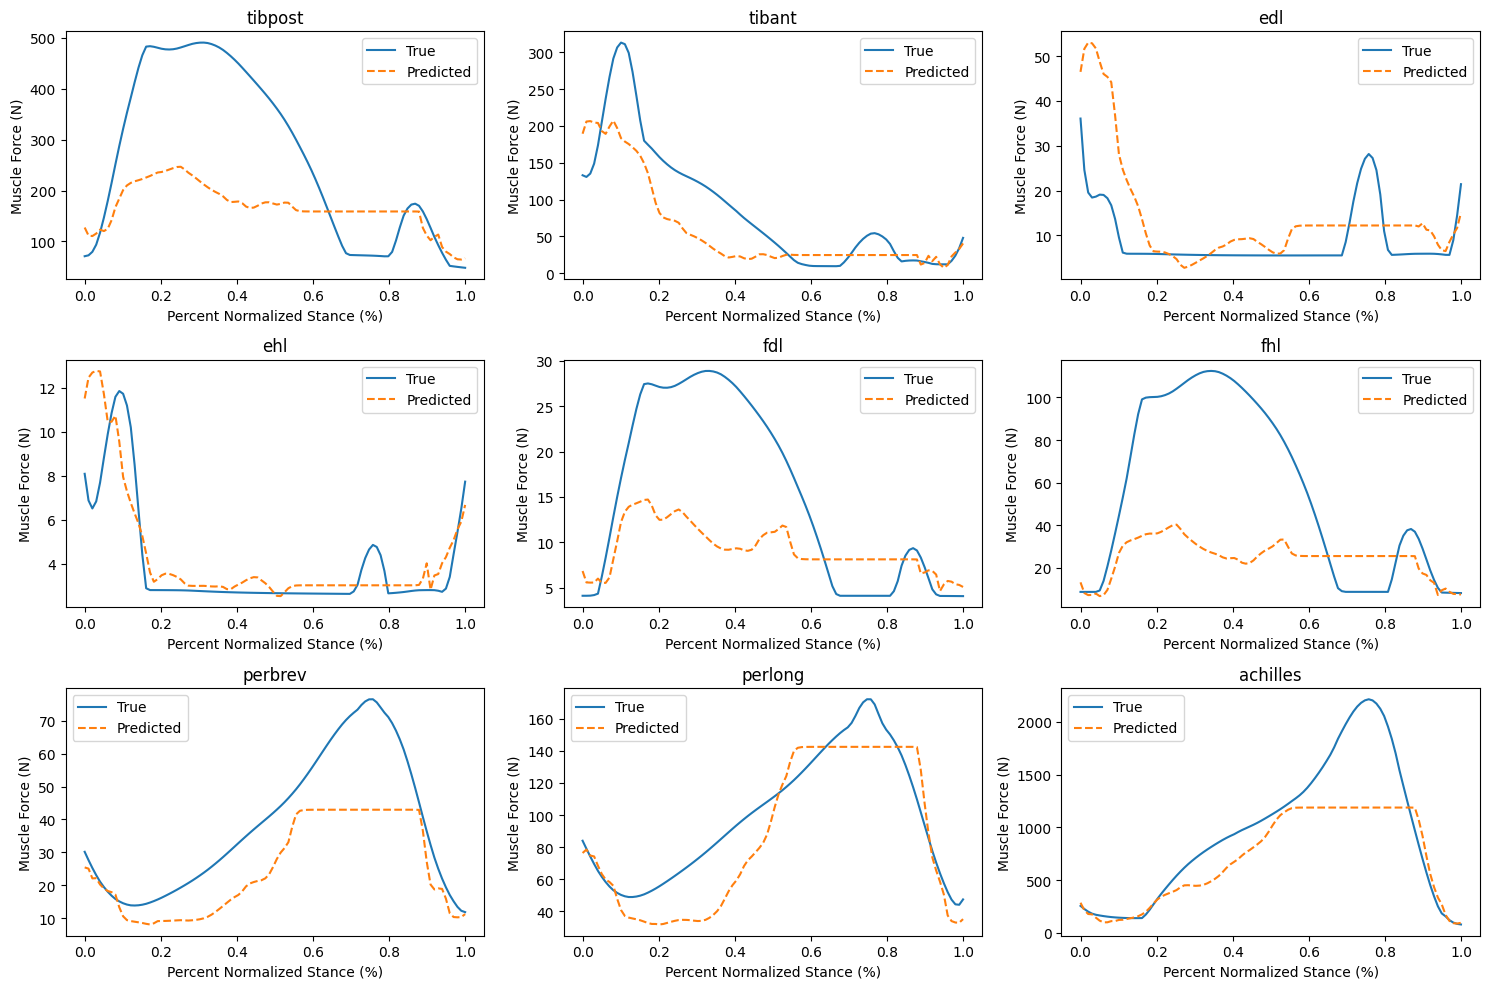

In [10]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)